In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib as mat
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.feature_selection import RFE,SelectFromModel,SelectKBest,chi2,VarianceThreshold
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.layers import Dense,Dropout,LSTM,GRU, Bidirectional
from tensorflow.keras.models import Sequential
import xgboost as xg 
from xgboost import plot_importance
import lightgbm as lgb
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_squared_error, mean_absolute_error, explained_variance_score, r2_score,mean_absolute_percentage_error
from ngboost import NGBRegressor
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal
from ngboost.scores import MLE
import plotly.express as px
from chart_studio import plotly
import plotly as py
import plotly.graph_objects as go
from itertools import cycle
from plotly.subplots import make_subplots
import datetime as dt
import yfinance as yf
import fix_yahoo_finance
import math
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import pmdarima as pm
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from datetime import datetime,date
import warnings
warnings.filterwarnings('ignore')

C:\Users\riaju\AppData\Local\Programs\Python\Python310\lib\site-packages\fix_yahoo_finance\__init__.py:0: DeprecationWarning: 

*** `fix_yahoo_finance` was renamed to `yfinance`. ***
Please install and use `yfinance` directly using `pip install yfinance -U`

More information: https://github.com/ranaroussi/yfinance



# Read Dataset

In [70]:
cryptocurrency=['BTC-USD']
start=dt.datetime(2018,1,1)
end=dt.datetime.now()
data= yf.download(cryptocurrency, start, end)
#data=pd.DataFrame(data)
data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-26,34504.289062,34832.910156,33762.324219,34156.648438,34156.648438,19427195376
2023-10-27,34156.500000,34238.210938,33416.886719,33909.800781,33909.800781,16418032871
2023-10-28,33907.722656,34399.390625,33874.804688,34089.574219,34089.574219,10160330825
2023-10-29,34089.371094,34743.261719,33947.566406,34538.480469,34538.480469,11160323986
2023-10-30,34531.742188,34575.640625,34210.324219,34210.324219,34210.324219,12941704192


In [71]:
data=data.drop(data[['Adj Close','Volume']],axis=1)
data.head()

,Open,High,Low,Close
Date,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000


In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2129 entries, 2018-01-01 to 2023-10-30
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2129 non-null   float64
 1   High    2129 non-null   float64
 2   Low     2129 non-null   float64
 3   Close   2129 non-null   float64
dtypes: float64(4)
memory usage: 83.2 KB


In [73]:
data.isna().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

In [74]:
data.describe()

,Open,High,Low,Close
count,2129.000000,2129.000000,2129.000000,2129.000000
mean,21232.724427,21723.359734,20695.765467,21240.163913
std,15939.173013,16343.752383,15477.633773,15936.887706
min,3236.274658,3275.377930,3191.303467,3236.761719
25%,8246.037109,8408.516602,8031.220215,8243.720703
50%,16611.636719,16771.474609,16416.228516,16618.199219
75%,30274.320312,30664.976562,29679.158203,30295.806641
max,67549.734375,68789.625000,66382.062500,67566.828125


# check correlation

In [75]:
correlations = data.corr(method='pearson') #spearman,pearson,kendall
print(correlations["Close"].sort_values(ascending=False))

Close    1.000000
High     0.999174
Low      0.999035
Open     0.998176
Name: Close, dtype: float64


# Visualize the data

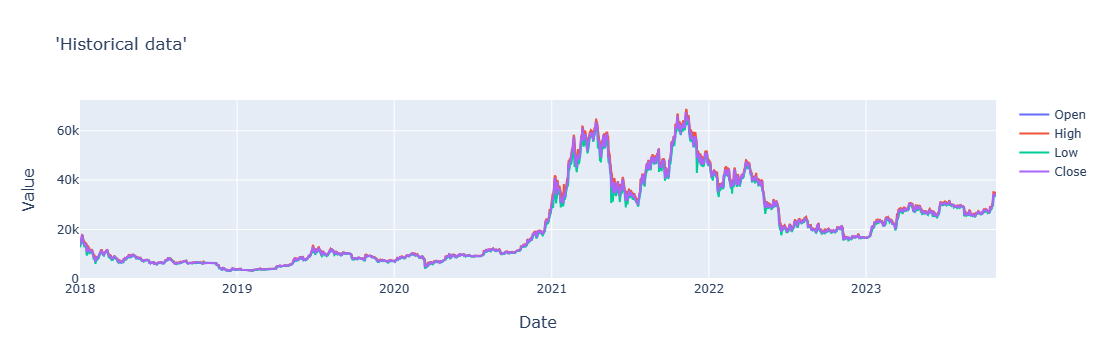

In [76]:
fig = make_subplots(rows=1, cols=1,x_title='Date',
                    y_title='Value')
for d in data:
    fig.add_trace((go.Scatter(x=data.index, y=data[d], name = d,connectgaps=False)), row=1, col=1)

fig.update_layout(title=dict(text="'Historical data'"))
fig.show()

# LSTM

### Prepare the dataset for training and test

In [77]:
start_date=dt.datetime(2018,1,1)
end_date=dt.datetime.now()
train_test_data=data.loc[(data.index>=start_date ) & (data.index<=end_date) ]
train_test_data

,Open,High,Low,Close
Date,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000
...,...,...,...,...
2023-10-26,34504.289062,34832.910156,33762.324219,34156.648438
2023-10-27,34156.500000,34238.210938,33416.886719,33909.800781
2023-10-28,33907.722656,34399.390625,33874.804688,34089.574219


In [78]:
train_test_data

,Open,High,Low,Close
Date,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000
...,...,...,...,...
2023-10-26,34504.289062,34832.910156,33762.324219,34156.648438
2023-10-27,34156.500000,34238.210938,33416.886719,33909.800781
2023-10-28,33907.722656,34399.390625,33874.804688,34089.574219


In [79]:
train_test_data=train_test_data.drop(train_test_data[['Open','High','Low']],axis=1)
train_test_data

,Close
Date,
2018-01-01,13657.200195
2018-01-02,14982.099609
2018-01-03,15201.000000
2018-01-04,15599.200195
2018-01-05,17429.500000
...,...
2023-10-26,34156.648438
2023-10-27,33909.800781
2023-10-28,34089.574219


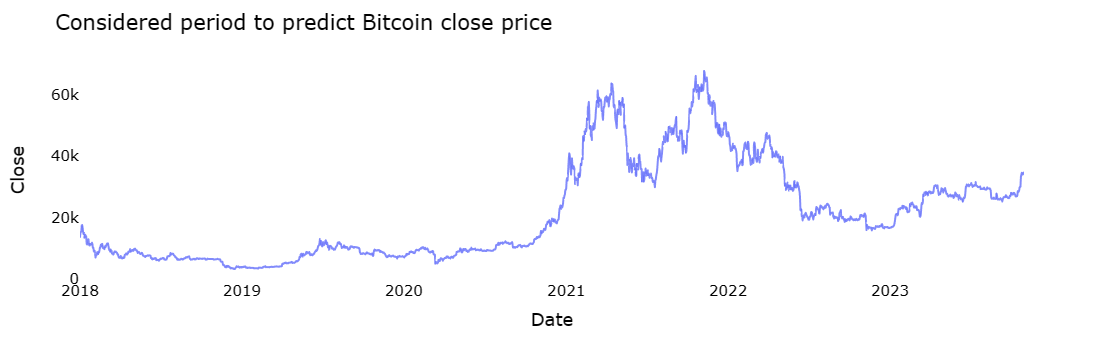

In [80]:
fig = px.line(train_test_data, x=train_test_data.index, y=train_test_data.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Bitcoin close price', 
                  plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [81]:
close_data=train_test_data.copy()

# Split the data for train and test

In [82]:
train_size = int(len(train_test_data) * 0.75) # 75% dataset for train and rest of data for test
train_data, test_data = train_test_data[:train_size], train_test_data[train_size:]

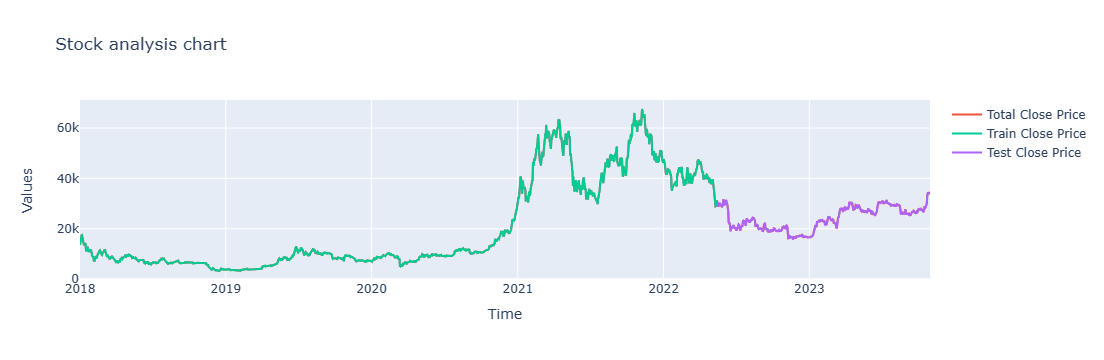

In [83]:
fig=px.line(title='Stock analysis chart').update_layout(
    xaxis_title="Time", yaxis_title="Values")
fig.add_scatter(x=data.index, y= data['Close'], name= "Total Close Price")
fig.add_scatter(x=train_data.index, y= train_data['Close'], name= "Train Close Price")
fig.add_scatter(x=test_data.index, y=test_data['Close'], name= "Test Close Price")

In [84]:
# Scale the data
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data[['Close']])
scaled_test_data = scaler.transform(test_data[['Close']])

# Create the model

In [85]:
# Initialising the LSTM
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50,activation='relu', return_sequences = True,input_shape=(1, 1)))# input_shape = (X_train.shape[1], 1)
regressor.add(Dropout(0.2))

# #Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 80,activation='relu', return_sequences = True))
regressor.add(Dropout(0.3))

#Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 80,activation='relu', return_sequences = True))
regressor.add(Dropout(0.4))

#Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 120,activation='relu'))
regressor.add(Dropout(0.5))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics="mean_absolute_error")
regressor.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1, 50)             10400     
                                                                 
 dropout_8 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_9 (LSTM)               (None, 1, 80)             41920     
                                                                 
 dropout_9 (Dropout)         (None, 1, 80)             0         
                                                                 
 lstm_10 (LSTM)              (None, 1, 80)             51520     
                                                                 
 dropout_10 (Dropout)        (None, 1, 80)             0         
                                                                 
 lstm_11 (LSTM)              (None, 120)              

In [86]:
# Fitting the RNN to the Training set
history = regressor.fit(np.expand_dims(scaled_train_data, axis=-1),
                              np.expand_dims(scaled_train_data, axis=-1), epochs = 50, batch_size = 64, verbose=1)#biki change the epochs to 200

Epoch 1/50
25/25 [==============================] - 5s 7ms/step - loss: 0.1305 - mean_absolute_error: 0.2338
Epoch 2/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0902 - mean_absolute_error: 0.2202
Epoch 3/50
25/25 [==============================] - 0s 5ms/step - loss: 0.0714 - mean_absolute_error: 0.2428
Epoch 4/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0474 - mean_absolute_error: 0.1936
Epoch 5/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0140 - mean_absolute_error: 0.0921
Epoch 6/50
25/25 [==============================] - 0s 8ms/step - loss: 0.0120 - mean_absolute_error: 0.0663
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0084 - mean_absolute_error: 0.0601
Epoch 8/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0089 - mean_absolute_error: 0.0587
Epoch 9/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0074 - mean_absolute_error: 0.0549
Epoch 10/50
25/25 [

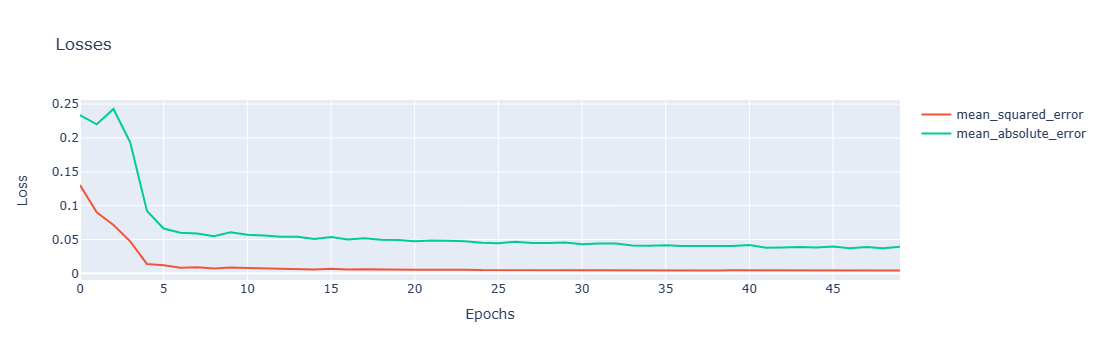

In [87]:
loss = history.history['loss']
val_loss = history.history['mean_absolute_error']

fig=px.line(title='Losses').update_layout(
    xaxis_title="Epochs", yaxis_title="Loss")
fig.add_scatter( y= loss, name= "mean_squared_error")
fig.add_scatter( y= val_loss, name= "mean_absolute_error")

# Prediction and check performance of model

In [88]:
### Lets Do the prediction and check performance metrics
train_predict=regressor.predict(np.expand_dims(scaled_train_data, axis=-1))
test_predict=regressor.predict(np.expand_dims(scaled_test_data, axis=-1))
train_predict.shape, test_predict.shape

17/17 [==============================] - 0s 2ms/step


((1596, 1), (533, 1))

In [89]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [90]:
test_predict

array([[29656.115 ],
       [30286.676 ],
       [28363.03  ],
       [30162.129 ],
       [28908.53  ],
       [29170.545 ],
       [30172.621 ],
       [28793.191 ],
       [29422.705 ],
       [29317.545 ],
       [28983.812 ],
       [28257.406 ],
       [28470.725 ],
       [29186.068 ],
       [31725.275 ],
       [31797.504 ],
       [29584.31  ],
       [30333.123 ],
       [29477.701 ],
       [29622.373 ],
       [29705.281 ],
       [31334.346 ],
       [31096.914 ],
       [30050.316 ],
       [29935.691 ],
       [28776.07  ],
       [27952.775 ],
       [26107.148 ],
       [21314.148 ],
       [21008.895 ],
       [21406.977 ],
       [19256.826 ],
       [19338.465 ],
       [18015.355 ],
       [19412.76  ],
       [19454.771 ],
       [19555.582 ],
       [18897.762 ],
       [19895.791 ],
       [20027.764 ],
       [20276.055 ],
       [19842.727 ],
       [19578.158 ],
       [19164.982 ],
       [19004.287 ],
       [18713.406 ],
       [18243.988 ],
       [18219

In [91]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(train_data['Close'],train_predict)))
print("Train data MSE: ", mean_squared_error(train_data['Close'],train_predict))
print("Train data MAE: ", mean_absolute_error(train_data['Close'],train_predict))
print("Train data MAPE: ",mean_absolute_percentage_error(train_data['Close'],train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test_data['Close'],test_predict)))
print("Test data MSE: ", mean_squared_error(test_data['Close'],test_predict))
print("Test data MAE: ", mean_absolute_error(test_data['Close'],test_predict))
print("Test data MAPE: ", mean_absolute_percentage_error(test_data['Close'],test_predict))

Train data RMSE:  1662.306275140094
Train data MSE:  2763262.152370134
Train data MAE:  1029.1767492461622
Train data MAPE:  0.11515541496401575
-------------------------------------------------------------------------------------
Test data RMSE:  827.6502861554609
Test data MSE:  685004.9961732163
Test data MAE:  747.3761304672843
Test data MAPE:  0.034090488416306935


In [92]:
print("Train data explained variance regression score:", 
      explained_variance_score(train_data['Close'], train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(test_data['Close'], test_predict))

Train data explained variance regression score: 0.9918771273962265
Test data explained variance regression score: 0.9936084753454529


In [93]:
print("Train data R2 score:", r2_score(train_data['Close'], train_predict))
print("Test data R2 score:", r2_score(test_data['Close'], test_predict))

Train data R2 score: 0.9915670423917075
Test data R2 score: 0.967434131487998


In [94]:
print("Train data MGD: ", mean_gamma_deviance(train_data['Close'], train_predict))
print("Test data MGD: ", mean_gamma_deviance(test_data['Close'], test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(train_data['Close'], train_predict))
print("Test data MPD: ", mean_poisson_deviance(test_data['Close'], test_predict))

Train data MGD:  0.0282559653859781
Test data MGD:  0.0016226282088064909
----------------------------------------------------------------------
Train data MPD:  193.8149027556274
Test data MPD:  32.99396959052592


In [99]:
train=close_data.iloc[:train_size]
test=close_data.iloc[train_size:]
test['Predictionlstm']=test_predict
train['Predictionlstm']=train_predict

In [98]:
fig=px.line(title='Result Analysis').update_layout(
    xaxis_title="Time", yaxis_title="Values")
#fig.add_scatter(x= close_data.index, y=close_data['Close'], name= "Original Close Price")
fig.add_scatter(x=train.index, y= train['Close'], name= "Train Close Price")
fig.add_scatter(x=train.index, y= train['Predictionlstm'], name= "Train Predicted Close Price")
fig.add_scatter(x=test.index, y= test['Close'], name= "Test Close Price")
fig.add_scatter(x=test.index, y=test['Predictionlstm'], name= "Predicted Close Price")

# GRU Model 

In [101]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, activation='tanh', return_sequences=True, input_shape=(1, 1)))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=60, activation='tanh', return_sequences=True))
regressorGRU.add(Dropout(0.3))
# Third GRU layer
regressorGRU.add(GRU(units=80, activation='tanh', return_sequences=True))
regressorGRU.add(Dropout(0.4))
# Fourth GRU layer
regressorGRU.add(GRU(units=120, activation='tanh'))
regressorGRU.add(Dropout(0.5))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics="mean_absolute_error")
# Fitting to the training set
regressorGRU.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 50)             7950      
                                                                 
 dropout_12 (Dropout)        (None, 1, 50)             0         
                                                                 
 gru_1 (GRU)                 (None, 1, 60)             20160     
                                                                 
 dropout_13 (Dropout)        (None, 1, 60)             0         
                                                                 
 gru_2 (GRU)                 (None, 1, 80)             34080     
                                                                 
 dropout_14 (Dropout)        (None, 1, 80)             0         
                                                                 
 gru_3 (GRU)                 (None, 120)              

In [102]:
history=regressorGRU.fit(np.expand_dims(scaled_train_data, axis=-1),
                              np.expand_dims(scaled_train_data, axis=-1), epochs = 50, batch_size = 64) #biki change the epochs to 200

Epoch 1/50
25/25 [==============================] - 8s 7ms/step - loss: 0.0781 - mean_absolute_error: 0.2142
Epoch 2/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0149 - mean_absolute_error: 0.0930
Epoch 3/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_error: 0.0488
Epoch 4/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0054 - mean_absolute_error: 0.0431
Epoch 5/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0048 - mean_absolute_error: 0.0396
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0048 - mean_absolute_error: 0.0413
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_absolute_error: 0.0375
Epoch 8/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_absolute_error: 0.0383
Epoch 9/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0037 - mean_absolute_error: 0.0393
Epoch 10/50
25/25 [

# Prediction and check performance of model

In [103]:
### Lets Do the prediction and check performance metrics
gru_train_predict=regressorGRU.predict(np.expand_dims(scaled_train_data, axis=-1))
gru_test_predict=regressorGRU.predict(np.expand_dims(scaled_test_data, axis=-1))
gru_train_predict.shape, gru_test_predict.shape

17/17 [==============================] - 0s 2ms/step


((1596, 1), (533, 1))

In [104]:
# Transform back to original form
gru_train_predict = scaler.inverse_transform(gru_train_predict)
gru_test_predict = scaler.inverse_transform(gru_test_predict)

In [106]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(train_data['Close'],gru_train_predict)))
print("Train data MSE: ", mean_squared_error(train_data['Close'],gru_train_predict))
print("Train data MAE: ", mean_absolute_error(train_data['Close'],gru_train_predict))
print("Train data MAPE: ",mean_absolute_percentage_error(train_data['Close'],gru_train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test_data['Close'],gru_test_predict)))
print("Test data MSE: ", mean_squared_error(test_data['Close'],gru_test_predict))
print("Test data MAE: ", mean_absolute_error(test_data['Close'],gru_test_predict))
print("Test data MAPE: ", mean_absolute_percentage_error(test_data['Close'],gru_test_predict))

Train data RMSE:  672.6762681018707
Train data MSE:  452493.36166745995
Train data MAE:  543.8058953536184
Train data MAPE:  0.03311026408226754
-------------------------------------------------------------------------------------
Test data RMSE:  1113.870833585154
Test data MSE:  1240708.233911686
Test data MAE:  1102.781290308396
Test data MAPE:  0.045962913301753075


In [107]:
print("Train data explained variance regression score:", 
      explained_variance_score(train_data['Close'], gru_train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(test_data['Close'], gru_test_predict))

Train data explained variance regression score: 0.999177889187969
Test data explained variance regression score: 0.9988313616678959


In [108]:
print("Train data R2 score:", r2_score(train_data['Close'], gru_train_predict))
print("Test data R2 score:", r2_score(test_data['Close'], gru_test_predict))

Train data R2 score: 0.9986190751631355
Test data R2 score: 0.9410154065546272


In [109]:
print("Train data MGD: ", mean_gamma_deviance(train_data['Close'], gru_train_predict))
print("Test data MGD: ", mean_gamma_deviance(test_data['Close'], gru_test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(train_data['Close'], gru_train_predict))
print("Test data MPD: ", mean_poisson_deviance(test_data['Close'], gru_test_predict))

Train data MGD:  0.0011745001489319891
Test data MGD:  0.0019942458551959258
----------------------------------------------------------------------
Train data MPD:  17.8633319711321
Test data MPD:  48.87828999306888


In [110]:
test['PredictionGru']=gru_test_predict
train['PredictionGru']=gru_train_predict

In [111]:
fig=px.line(title='Result Analysis').update_layout(
    xaxis_title="Time", yaxis_title="Values")
#fig.add_scatter(x= close_data.index, y=close_data['Close'], name= "Original Close Price")
fig.add_scatter(x=train.index, y= train['Close'], name= "Train Close Price")
fig.add_scatter(x=train.index, y= train['PredictionGru'], name= "Train Predicted Close Price")
fig.add_scatter(x=test.index, y= test['Close'], name= "Test Close Price")
fig.add_scatter(x=test.index, y=test['PredictionGru'], name= "Predicted Close Price")

# Birectional LSTM

In [112]:
# The bidir architecture
regressorbidir = Sequential()
# First bidir layer with Dropout regularisation
regressorbidir.add(Bidirectional(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(1, 1))))
regressorbidir.add(Dropout(0.2))
# Second bidir layer
regressorbidir.add(Bidirectional(LSTM(units=60, activation='relu', return_sequences=True)))
regressorbidir.add(Dropout(0.3))
# Third bidir layer
regressorbidir.add(Bidirectional(LSTM(units=80, activation='relu', return_sequences=True)))
regressorbidir.add(Dropout(0.4))
# Fourth bidir layer
regressorbidir.add(Bidirectional(LSTM(units=120, activation='relu')))
regressorbidir.add(Dropout(0.5))
# The output layer
regressorbidir.add(Dense(units=1))
# Compiling the RNN
regressorbidir.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics="mean_absolute_error")
# Fitting to the training set
# regressorbidir.summary()

In [44]:
# from tensorflow.keras.callbacks import EarlyStopping
# monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
#         verbose=1, mode='auto', restore_best_weights=True)

In [113]:
history=regressorbidir.fit(np.expand_dims(scaled_train_data, axis=-1),
                              np.expand_dims(scaled_train_data, axis=-1), epochs = 50, batch_size = 64) #biki change the epochs to 200regressorbidir

Epoch 1/50
25/25 [==============================] - 10s 9ms/step - loss: 0.1221 - mean_absolute_error: 0.2258
Epoch 2/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0716 - mean_absolute_error: 0.2378
Epoch 3/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0321 - mean_absolute_error: 0.1555
Epoch 4/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0065 - mean_absolute_error: 0.0563
Epoch 5/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0054 - mean_absolute_error: 0.0476
Epoch 6/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_absolute_error: 0.0421
Epoch 7/50
25/25 [==============================] - 0s 11ms/step - loss: 0.0038 - mean_absolute_error: 0.0378
Epoch 8/50
25/25 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_absolute_error: 0.0394
Epoch 9/50
25/25 [==============================] - 0s 11ms/step - loss: 0.0033 - mean_absolute_error: 0.0362
Epoch 10/50
25/

In [114]:
regressorbidir.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 100)           20800     
 l)                                                              
                                                                 
 dropout_16 (Dropout)        (None, 1, 100)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 120)           77280     
 nal)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 1, 120)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 1, 160)           128640    
 nal)                                                            
                                                      

# Prediction and check performance of model

In [115]:
### Lets Do the prediction and check performance metrics
bidir_train_predict=regressorbidir.predict(np.expand_dims(scaled_train_data, axis=-1))
bidir_test_predict=regressorbidir.predict(np.expand_dims(scaled_test_data, axis=-1))
bidir_train_predict.shape, bidir_test_predict.shape

17/17 [==============================] - 0s 2ms/step


((1596, 1), (533, 1))

In [116]:
# Transform back to original form
bidir_train_predict = scaler.inverse_transform(bidir_train_predict)
bidir_test_predict = scaler.inverse_transform(bidir_test_predict)

In [117]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(train_data['Close'],bidir_train_predict)))
print("Train data MSE: ", mean_squared_error(train_data['Close'],bidir_train_predict))
print("Train data MAE: ", mean_absolute_error(train_data['Close'],bidir_train_predict))
print("Train data MAPE: ",mean_absolute_percentage_error(train_data['Close'],bidir_train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test_data['Close'],bidir_test_predict)))
print("Test data MSE: ", mean_squared_error(test_data['Close'],bidir_test_predict))
print("Test data MAE: ", mean_absolute_error(test_data['Close'],bidir_test_predict))
print("Test data MAPE: ", mean_absolute_percentage_error(test_data['Close'],bidir_test_predict))

Train data RMSE:  1264.5067715416053
Train data MSE:  1598977.3752745735
Train data MAE:  912.79131055177
Train data MAPE:  0.09488821856455933
-------------------------------------------------------------------------------------
Test data RMSE:  896.0021781631755
Test data MSE:  802819.9032731549
Test data MAE:  891.5489673721858
Test data MAPE:  0.03828214083236191


In [118]:
print("Train data explained variance regression score:", 
      explained_variance_score(train_data['Close'], bidir_train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(test_data['Close'], bidir_test_predict))

Train data explained variance regression score: 0.996219284976775
Test data explained variance regression score: 0.999621556844135


In [119]:
print("Train data R2 score:", r2_score(train_data['Close'], bidir_train_predict))
print("Test data R2 score:", r2_score(test_data['Close'], bidir_test_predict))

Train data R2 score: 0.9951202210724944
Test data R2 score: 0.9618330850798632


In [120]:
print("Train data MGD: ", mean_gamma_deviance(train_data['Close'], bidir_train_predict))
print("Test data MGD: ", mean_gamma_deviance(test_data['Close'], bidir_test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(train_data['Close'], bidir_train_predict))
print("Test data MPD: ", mean_poisson_deviance(test_data['Close'], bidir_test_predict))

Train data MGD:  0.016556671632426537
Test data MGD:  0.001621557623199115
----------------------------------------------------------------------
Train data MPD:  17.8633319711321
Test data MPD:  48.87828999306888


In [123]:
test['Predictionbidir']=bidir_test_predict
train['Predictionbidir']=bidir_train_predict

In [124]:
fig=px.line(title='Result Analysis').update_layout(
    xaxis_title="Time", yaxis_title="Values")
#fig.add_scatter(x= close_data.index, y=close_data['Close'], name= "Original Close Price")
fig.add_scatter(x=train.index, y= train['Close'], name= "Train Close Price")
fig.add_scatter(x=train.index, y= train['Predictionbidir'], name= "Train Predicted Close Price")
fig.add_scatter(x=test.index, y= test['Close'], name= "Test Close Price")
fig.add_scatter(x=test.index, y=test['Predictionbidir'], name= "Predicted Close Price")